In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [3]:
dirPath = "data preprocessed\\unnormalized\\keep-all-necessary-feature"

#means, stds = eval(open(dirPath + "\\means_and_stds_about_trainset.py").read())

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((13625, 76), (2990, 76), (742, 75))

划分数据集特征和标签：

In [4]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]

trainSet.shape, validateSet.shape

((13625, 75), (2990, 75))

# 划分验证集最后21天进行测试

由于之前划分验证集时是直接取原有数据集的后18%作为验证集的，这里取验证集的后21天作为测试也相当于取原有数据集的后21天作为测试，保存了数据在时间上的连续性。

In [5]:
num = 21*24 # 数据个数
last21Days_range = np.arange(num) #样本范围
last21Days_features, last21Days_labels_origin = validateSet[-num:], validateSetLabel[-num:]

last21Days_labels_origin.shape, last21Days_range.shape

((504,), (504,))

# 损失函数实现

这里实现损失函数来衡量算法的准确率。

In [1]:
def calcLoss(predict, label):
    '''计算预测值相对于标签值的损失值，默认使用均方误差'''
    def RMeanSquareError(a, b):
        '''计算均方误差'''
        return np.sqrt(np.mean((a - b)**2))
    
    return RMeanSquareError(predict, label)

# KNN

In [7]:
def knn_classify(dataSet, labels, k, inputVector):
    '''使用knn对输入的向量进行分类，使用欧式距离'''
    #得到输入向量与数据集的差值的平方
    diffMat = (dataSet - inputVector)**2
    #计算每一行上元素的和
    distancesSquare = diffMat.sum(axis=1)
    #可以不用计算距离，用距离的平方也可以，这样效率更高

    #得到 K 个近邻的下标
    kNeighborsIndex  = distancesSquare.argpartition(k-1)[0:k]
    
    #计算 K 个近邻的距离倒数
    kDatas = 1/distancesSquare[kNeighborsIndex]
    #得到 对应的 K 个标签
    kLabels = labels[kNeighborsIndex]

    predictLabel = np.mean(kLabels)
    #返回分类结果
    return predictLabel

##############测试程序#######################
knn_classify(arr([[1,1,0,0],
              [0,1,1,1],
              [1,0,0,1]]), arr([1, 0, 1]), 3, arr([0,1,1,0]))
##############测试程序#######################

0.66666666666666663

# 调参

所调参数只有K。

In [8]:
def run_knn_classify(dataSet, k):
    ansLabel = []
    for i in tnrange(len(dataSet), leave=False):
        ansLabel.append(knn_classify(trainSet, trainSetLabel, k, dataSet[i]))
    return arr(ansLabel)

def getTestLoss(k):
    ansLabel = run_knn_classify(validateSet, k)
    return calcLoss(ansLabel, validateSetLabel)

In [24]:
testRange = np.arange(1, 31)
testRange

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [25]:
loss = []
for k in tnrange(1, len(testRange)+1):
    loss.append(getTestLoss(k))

In [26]:
bestK = testRange[np.argmin(loss)]
bestK, np.min(loss) 

(16, 150.44063855812479)

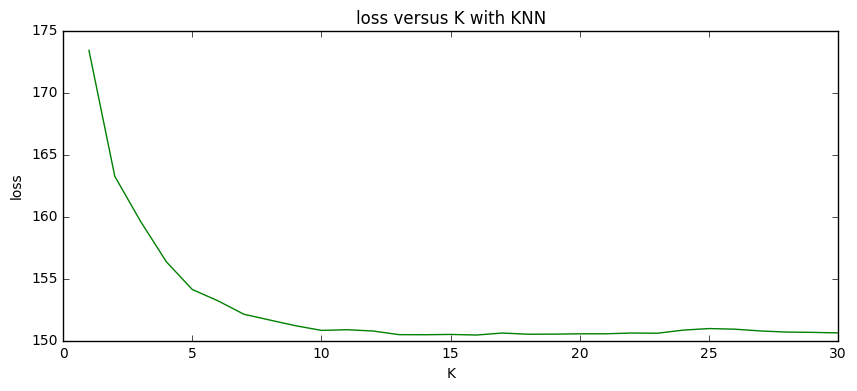

In [27]:
def plot_fig():
    fig,ax = plt.subplots() 
    fig.set_size_inches(10, 4)
    plt.plot(testRange, loss, 'g')
    plt.xlabel('K')
    plt.ylabel('loss')
    plt.title("loss versus K with KNN")
    plt.show()
    plt.close()

plot_fig()

# 测试在验证集后21天的MSE


In [40]:
last21Days_predicts = run_knn_classify(last21Days_features, 9)
calcLoss(last21Days_predicts, last21Days_labels_origin)

126.32500803408206

In [31]:
last21Days_predicts = run_knn_classify(last21Days_features, bestK)
calcLoss(last21Days_predicts, last21Days_labels_origin)

125.67665454162835

# 绘制对验证集后21天的预测值与实际值的对比图

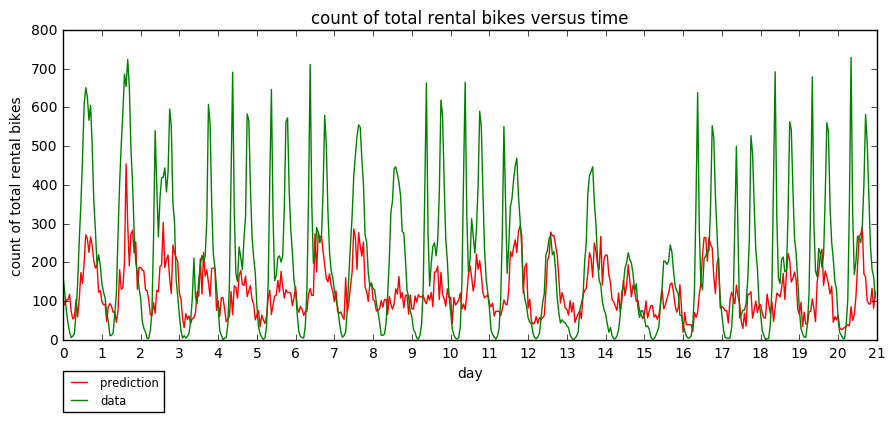

In [29]:
def show_last21Days_fig(test_range, predict, label, fileName="test_last21Days.png", showFig=True):
    fig, ax = plt.subplots() 
    fig.set_size_inches(10.5, 4)
    plt.plot(test_range, predict, 'r', label="prediction")
    plt.plot(test_range, label, 'g', label="data")
    ax.set_xlim(right=num)
    ax.set_xticks(np.arange(0, num+24, 24))
    ax.set_xticklabels(np.arange(0, 22, 1))
    plt.xlabel('day')
    plt.ylabel('count of total rental bikes')
    plt.title("count of total rental bikes versus time")
    plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
    if showFig:
        plt.show()
    else:
        plt.savefig(fileName)
    plt.close()

show_last21Days_fig(last21Days_range, last21Days_predicts, last21Days_labels_origin)    

12-26：

可以看到，KNN还是可以学习到时间序列的基本趋势的，但是总体效果还是很差。

rank数据：k=9 -------> RMSE=166.472

先测试16-23的测试集RMSE，估计应该可以比K=9时下降一点。

k= 16 loss= 165.281223221

k= 17 loss= 165.326206988

k= 18 loss= 165.400322994

k= 19 loss= 165.389151484

k= 20 loss= 165.639526775

k= 21 loss= 165.508356806

k= 22 loss= 165.394423618

k= 23 loss= 164.955564547

可以说，基本没什么改善了。

但是这里有个有趣的地方，k=23时效果反而是最好的。和猜想的有点贴近了，数据时周期性0-23变化的

In [32]:
ansLabel = run_knn_classify(testSet, k=bestK)
np.savetxt('.\\rank\\47_v1.csv', ansLabel, fmt="%d", delimiter="\n")

In [33]:
# ansLabel = run_knn_classify(testSet, k=17)
# np.savetxt('.\\rank\\47_v2.csv', ansLabel, fmt="%d", delimiter="\n")

In [34]:
# ansLabel = run_knn_classify(testSet, k=18)
# np.savetxt('.\\rank\\47_v3.csv', ansLabel, fmt="%d", delimiter="\n")

In [35]:
# ansLabel = run_knn_classify(testSet, k=19)
# np.savetxt('.\\rank\\47_v4.csv', ansLabel, fmt="%d", delimiter="\n")

In [36]:
# ansLabel = run_knn_classify(testSet, k=20)
# np.savetxt('.\\rank\\47_v5.csv', ansLabel, fmt="%d", delimiter="\n")

In [37]:
# ansLabel = run_knn_classify(testSet, k=21)
# np.savetxt('.\\rank\\47_v6.csv', ansLabel, fmt="%d", delimiter="\n")

In [38]:
# ansLabel = run_knn_classify(testSet, k=22)
# np.savetxt('.\\rank\\47_v7.csv', ansLabel, fmt="%d", delimiter="\n")

In [39]:
# ansLabel = run_knn_classify(testSet, k=23)
# np.savetxt('.\\rank\\47_v8.csv', ansLabel, fmt="%d", delimiter="\n")